## Project Overview
This notebook explores user acquisition, product interaction, and transaction behavior for an e-commerce platform. The analysis supports marketing funnel optimization and LTV tracking.

### Data Sources
- users_clean.xlsx: User-level info with signup channel and dates
- events_clean.xlsx: Logged events representing funnel interactions
- transactions_clean.xlsx: Purchase-level data for revenue analysis

All datasets were cleaned using Alteryx, then loaded into Python for analysis.

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt

users = pd.read_excel('users_clean.xlsx')
transactions = pd.read_excel('transactions_clean.xlsx')
events = pd.read_excel('events_clean.xlsx')

### Basic checks

In [3]:
print(users.shape)
print(events.shape)
print(transactions.shape)

(5000, 10)
(265230, 14)
(20925, 7)


### Check Nulls

In [4]:
print(users.isnull().sum())
print(events.isnull().sum())
print(transactions.isnull().sum())

user_id                0
signup_date            0
device_type            0
acquisition_channel    0
region                 0
is_kyc_completed       0
referral_source        0
signup_month           0
days_since_signup      0
device_web_flag        0
dtype: int64
event_id               0
user_id                0
event_time             0
event_type             0
platform               0
signup_date            0
device_type            0
acquisition_channel    0
region                 0
is_kyc_completed       0
referral_source        0
signup_month           0
days_since_signup      0
device_web_flag        0
dtype: int64
transaction_id    0
user_id           0
amount            0
category          0
payment_method    0
status            0
is_successful     0
dtype: int64


In [5]:
# Check unique event types
print(events['event_type'].value_counts())

# Transaction status
print(transactions['status'].value_counts())

event_type
app_open               79504
view_offer             52936
kyc_submit             26719
recharge_attempt       26549
logout                 26524
add_card               26507
transaction_success    26491
Name: count, dtype: int64
status
success    18879
failed      2046
Name: count, dtype: int64


### Funnel Event Drop-Off
Events are sequenced from App → KYC → Transaction. This helps identify where users are dropping off in the conversion process.

1. Users who opened the app
2. Users who submitted KYC
3. Users who had a successful transaction

In [6]:
# 1. App opened
app_open_users = events[events['event_type'] == 'app_open']['user_id'].unique()

# 2. KYC submitted
kyc_users = events[events['event_type'] == 'kyc_submit']['user_id'].unique()

# 3. Successful transactions
successful_users = transactions[transactions['is_successful'] == 1]['user_id'].unique()

# Funnel counts
print(f"App Opens: {len(app_open_users)}")
print(f"KYC Submits: {len(kyc_users)}")
print(f"Paid Users: {len(successful_users)}")


App Opens: 4971
KYC Submits: 4696
Paid Users: 1968


### Conversion Rate

In [7]:
print(f"KYC Conversion Rate: {len(kyc_users)/len(app_open_users):.2%}")
print(f"Payment Conversion Rate: {len(successful_users)/len(kyc_users):.2%}")
print(f"Overall Conversion Rate: {len(successful_users)/len(app_open_users):.2%}")



KYC Conversion Rate: 94.47%
Payment Conversion Rate: 41.91%
Overall Conversion Rate: 39.59%


### Retention & Cohort Analysis


0


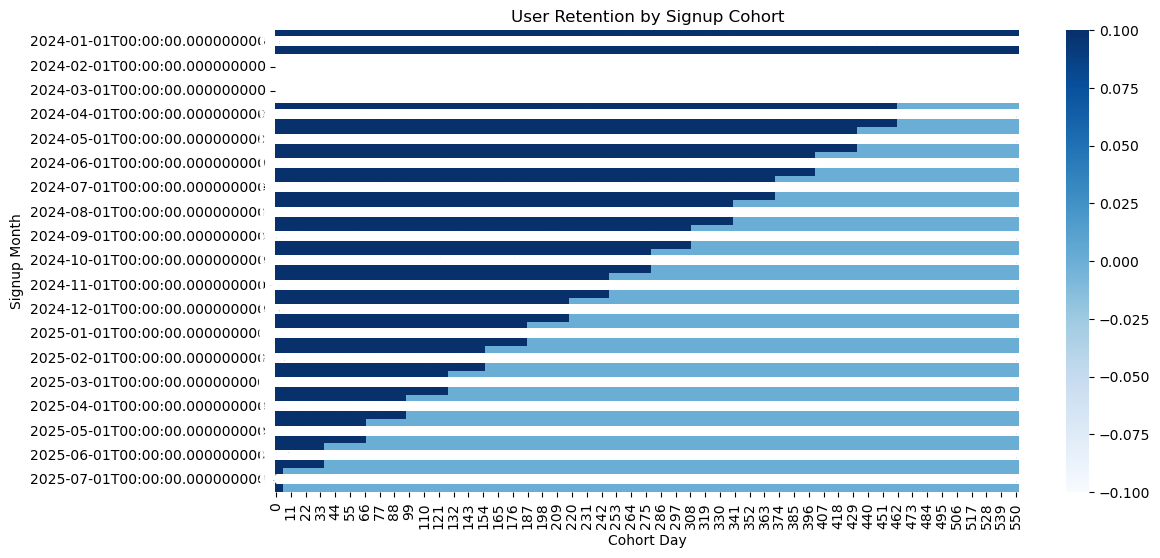

In [8]:
# 1. Convert signup_date to datetime
users['signup_date'] = pd.to_datetime(users['signup_date'])

# 2. Create signup_month
users['signup_month'] = users['signup_date'].dt.to_period('M').dt.to_timestamp()

# 3. Clean merge into events
if 'signup_month' in events.columns:
    events = events.drop(columns=['signup_month'])
events = events.merge(users[['user_id', 'signup_month']], on='user_id', how='left')

# 4. Sanity check
print(events['signup_month'].isnull().sum())  # Should be 0

# 5. Cohort day
events['event_time'] = pd.to_datetime(events['event_time'])
events['cohort_day'] = (events['event_time'] - events['signup_month']).dt.days

# 6. Create retention table
retention = events.groupby(['signup_month', 'cohort_day'])['user_id'].nunique().unstack().fillna(0)
retention_pct = retention.div(retention[0], axis=0)

# 7. Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.heatmap(retention_pct, annot=True, fmt=".0%", cmap="Blues")
plt.title("User Retention by Signup Cohort")
plt.xlabel("Cohort Day")
plt.ylabel("Signup Month")
plt.show()


###  Lifetime Value (LTV)
LTV is calculated as the sum of transaction amounts per user. We compare LTV across signup channels to assess customer quality by acquisition source.

In [9]:
# Convert signup_date to datetime and derive signup_month
users['signup_date'] = pd.to_datetime(users['signup_date'])
users['signup_month'] = users['signup_date'].dt.to_period('M').dt.to_timestamp()

# Merge signup_month into transactions
transactions = transactions.merge(users[['user_id', 'signup_month']], on='user_id', how='left')

# Total revenue per cohort
ltv = transactions.groupby('signup_month')['amount'].sum().reset_index()

# Active users per cohort
user_counts = users.groupby('signup_month')['user_id'].nunique().reset_index()

# Combine and calculate LTV
ltv = ltv.merge(user_counts, on='signup_month')
ltv.columns = ['signup_month', 'total_revenue', 'num_users']
ltv['ltv_per_user'] = ltv['total_revenue'] / ltv['num_users']


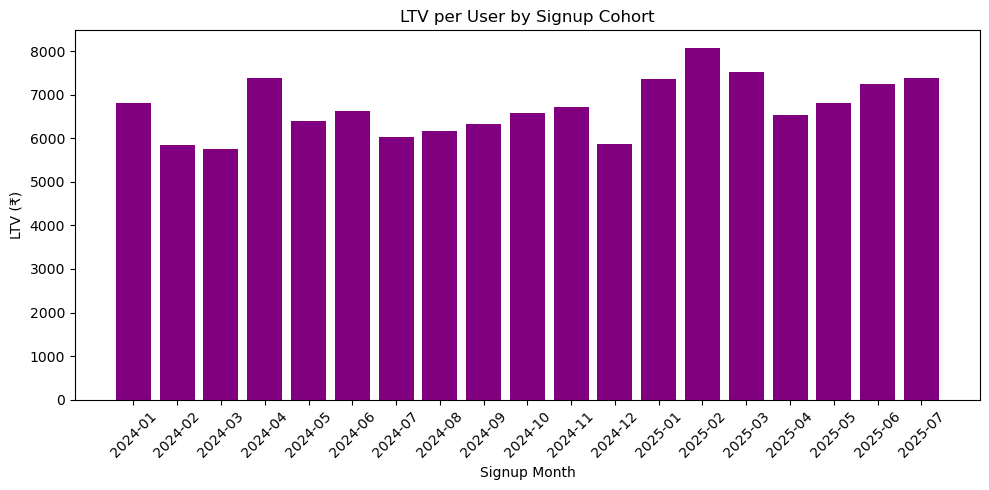

,signup_month,total_revenue,num_users,ltv_per_user
13,2025-02-01,2.090590e+06,259,8071.774868
14,2025-03-01,2.343929e+06,312,7512.593729
18,2025-07-01,3.251406e+05,44,7389.558426
3,2024-04-01,2.043695e+06,277,7377.958901
12,2025-01-01,2.124121e+06,289,7349.899970
17,2025-06-01,1.884529e+06,260,7248.189852
0,2024-01-01,1.819917e+06,267,6816.168240
16,2025-05-01,1.944770e+06,286,6799.894279
10,2024-11-01,1.791734e+06,267,6710.614870
5,2024-06-01,1.790935e+06,270,6633.093641


In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(ltv['signup_month'].dt.strftime('%Y-%m'), ltv['ltv_per_user'], color='purple')
plt.title("LTV per User by Signup Cohort")
plt.xlabel("Signup Month")
plt.ylabel("LTV (₹)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

ltv.sort_values('ltv_per_user', ascending=False)


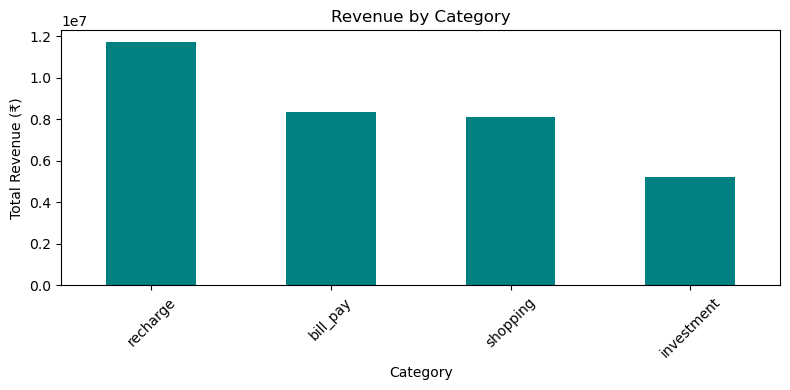

In [11]:
### Revenue by category:


rev_by_cat = transactions.groupby('category')['amount'].sum().sort_values(ascending=False)

plt.figure(figsize=(8, 4))
rev_by_cat.plot(kind='bar', color='teal')
plt.title("Revenue by Category")
plt.xlabel("Category")
plt.ylabel("Total Revenue (₹)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


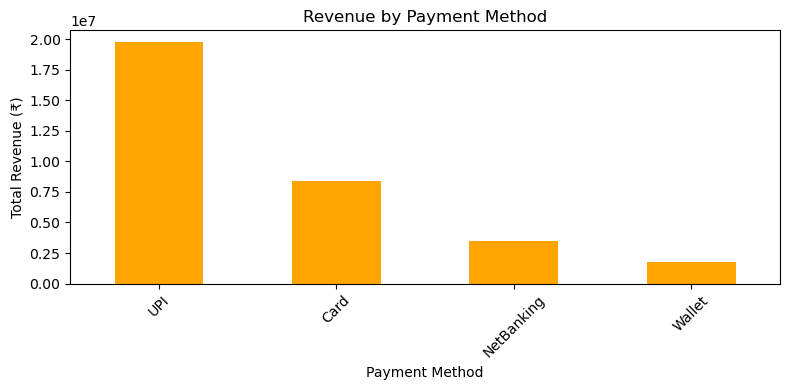

In [12]:
### Revenue by Payment Method
rev_by_method = transactions.groupby('payment_method')['amount'].sum().sort_values(ascending=False)

plt.figure(figsize=(8, 4))
rev_by_method.plot(kind='bar', color='orange')
plt.title("Revenue by Payment Method")
plt.xlabel("Payment Method")
plt.ylabel("Total Revenue (₹)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


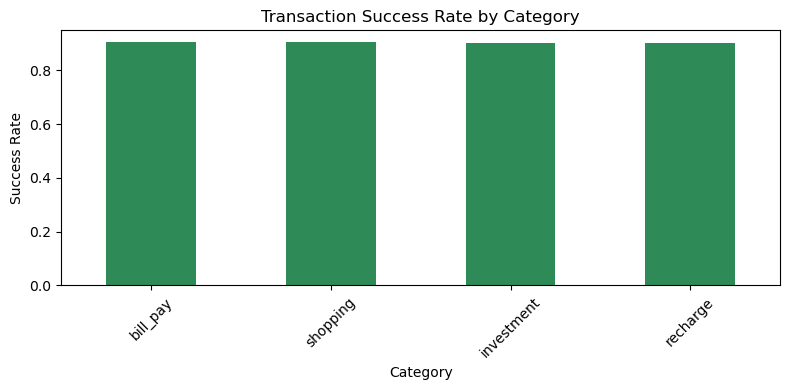

In [13]:
### Success Rate by Category

success_rate = transactions.groupby('category')['is_successful'].mean().sort_values(ascending=False)

plt.figure(figsize=(8, 4))
success_rate.plot(kind='bar', color='seagreen')
plt.title("Transaction Success Rate by Category")
plt.xlabel("Category")
plt.ylabel("Success Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
